チームわらわら　機械分析

In [ ]:
# pip install missingno

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
import  pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import missingno as msno

In [25]:
# CSVの読み込み
df = pd.read_csv("wwww_db.csv")

ピボット処理を行い、reception_idごとに1行にまとめるワイドフォーマットへの変換

In [32]:
df_wide_format = df.pivot_table(index="reception_id",
                                columns="question_id",
                                values=["answer_numeric", "answer_boolean", "answer_categorical"],
                                aggfunc="first")
# カラム名を整理（例: "q1_answer_numeric", "q2_answer_boolean" など）
df_wide_format.columns = [f"q{col[1]}_{col[0]}" for col in df_wide_format.columns]
df_wide_format.reset_index(inplace=True)

# print(df_wide_format.head())
# print("----------------------------------------------------------")

# q1とq4はカテゴリカルなのでエンコーディング実施
df_encoded = df_wide_format.copy()
# q1_answer_categorical（間取り情報）はラベルエンコーディング
le = LabelEncoder()
# 欠損値がある場合は、一旦文字列に変換して埋める（ここでは "missing" として扱う）
df_encoded["q1_answer_categorical"] = df_encoded["q1_answer_categorical"].fillna("missing")
df_encoded["q1_answer_categorical"] = le.fit_transform(df_encoded["q1_answer_categorical"])


# q4_answer_categorical はワンホットエンコーディング
df_encoded = pd.get_dummies(df_encoded, columns=["q4_answer_categorical"], prefix="q4_answer_categorical", dummy_na=True)
# ワンホットエンコーディングの結果がbooleanの場合、0/1の整数に変換
for col in df_encoded.columns:
    if col.startswith("q4_answer_categorical_"):
        df_encoded[col] = df_encoded[col].astype(int)

print(df_encoded.head(5))

   reception_id  q2_answer_boolean  q3_answer_boolean  q5_answer_boolean  \
0          1000                0.0                1.0                1.0   
1          1001                0.0                0.0                1.0   
2          1002                0.0                1.0                1.0   
3          1003                1.0                1.0                1.0   
4          1004                1.0                0.0                0.0   

   q6_answer_boolean  q1_answer_categorical  q7_answer_numeric  \
0                0.0                      1                5.0   
1                0.0                      2                5.0   
2                0.0                      1                3.0   
3                1.0                      0                1.0   
4                0.0                      1                2.0   

   q8_answer_numeric  q9_answer_numeric  q10_answer_numeric  \
0                5.0                2.0                 5.0   
1                1.0

データの可視化を実行
単変量可視化

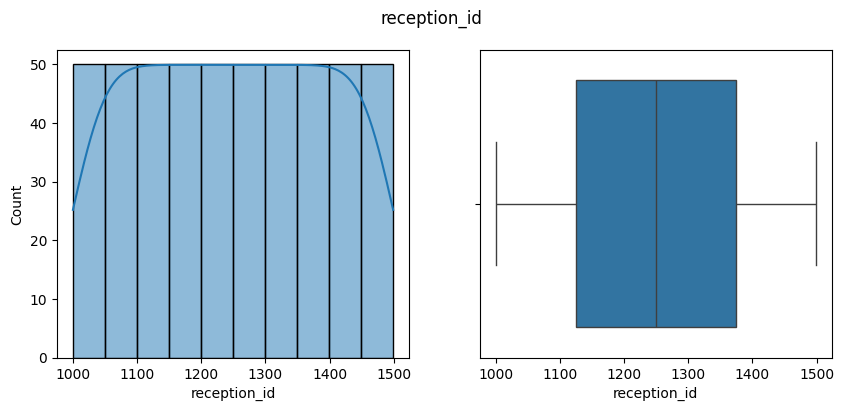

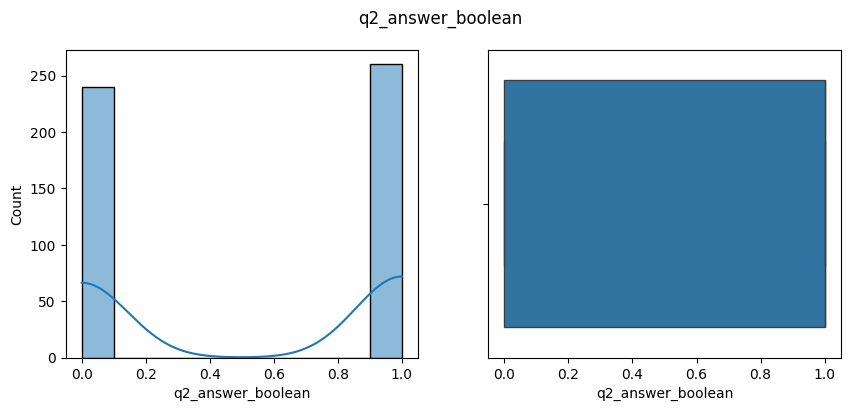

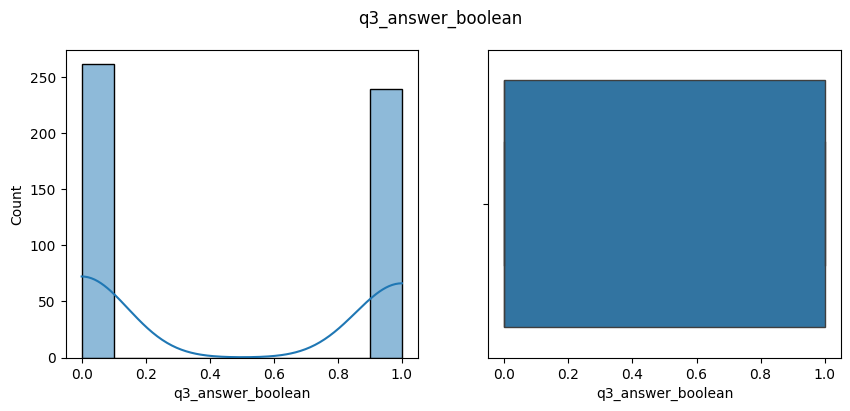

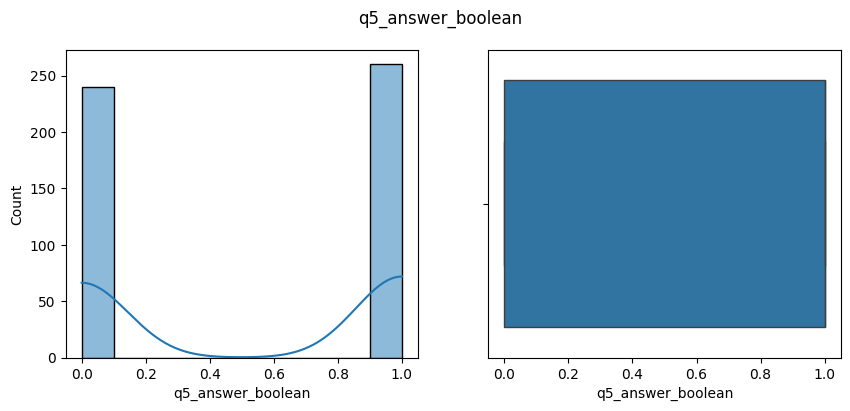

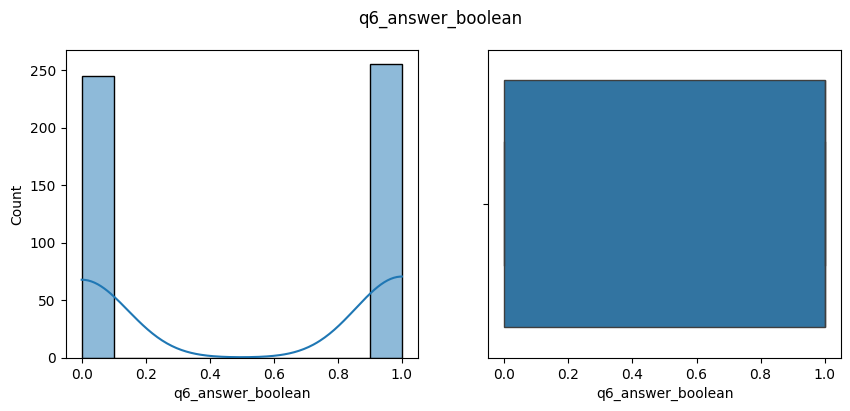

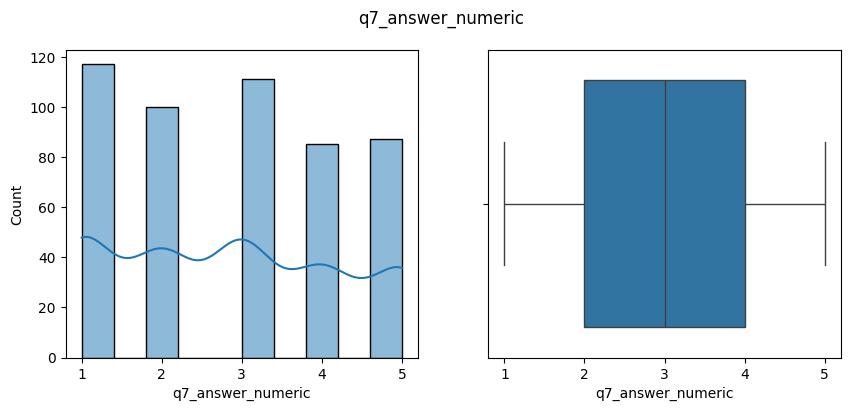

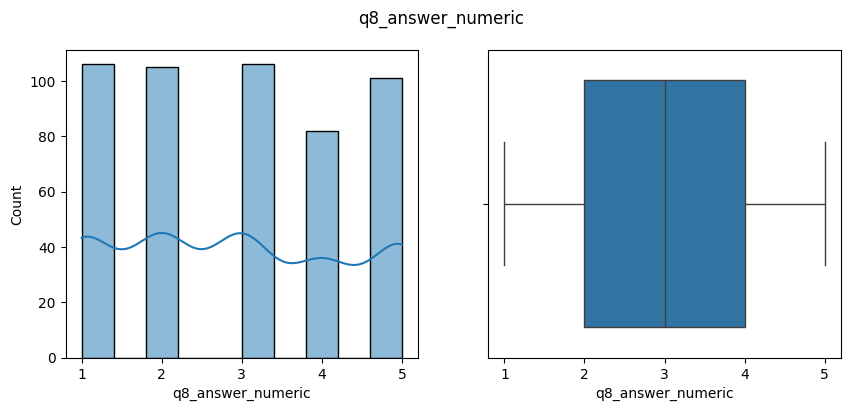

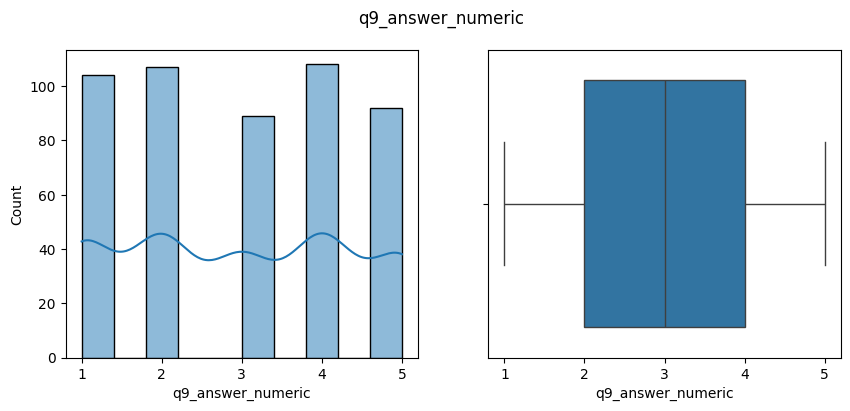

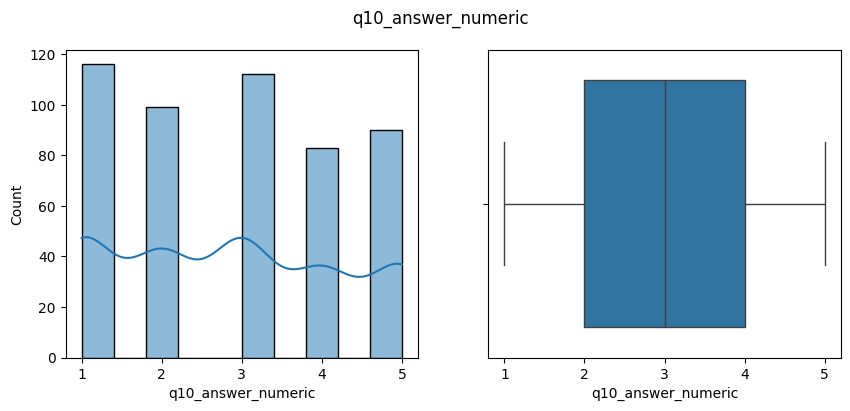

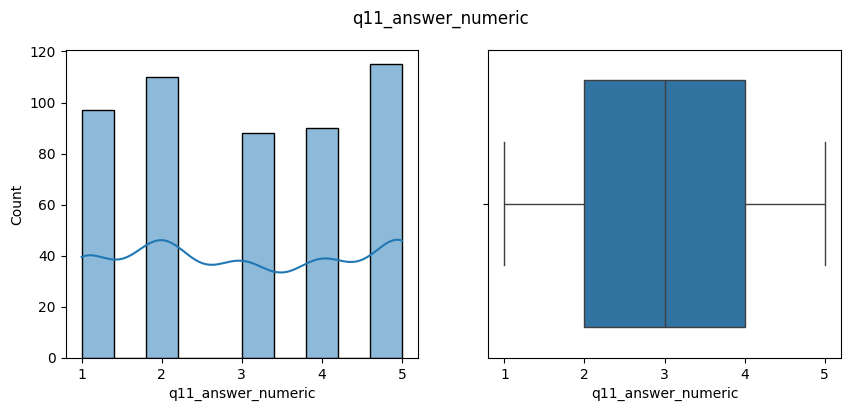

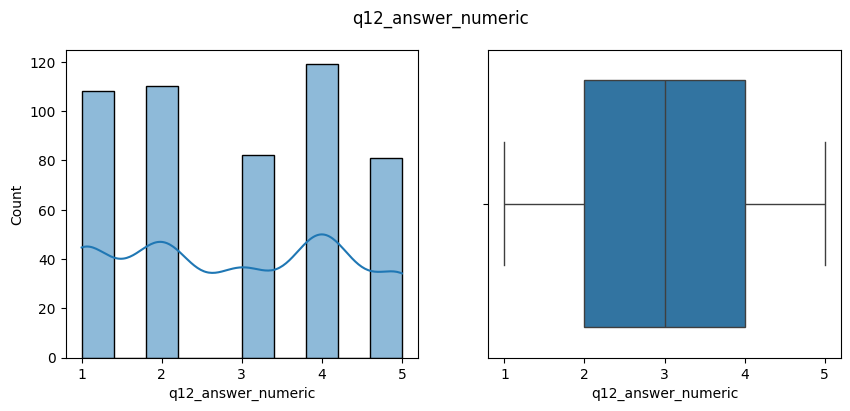

In [27]:
numeric_cols = df_encoded.select_dtypes(include=['int64','float64']).columns
for col in numeric_cols:
    fig, axes = plt.subplots(1,2, figsize=(10,4))
    sns.histplot(df_encoded[col].dropna(), ax=axes[0], kde=True)
    sns.boxplot(x=df_encoded[col], ax=axes[1])
    plt.suptitle(col)
    plt.show()

二変量可視化（相関ヒートマップ）


c:\Users\堀江雅彦\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 12393 (\N{HIRAGANA LETTER DO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\堀江雅彦\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 12385 (\N{HIRAGANA LETTER TI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\堀江雅彦\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 12425 (\N{HIRAGANA LETTER RA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\堀江雅彦\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 12418 (\N{HIRAGANA LETTER MO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\堀江雅彦\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 12456 (\N{KATAKANA LETTER E}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\堀江雅彦\Ap

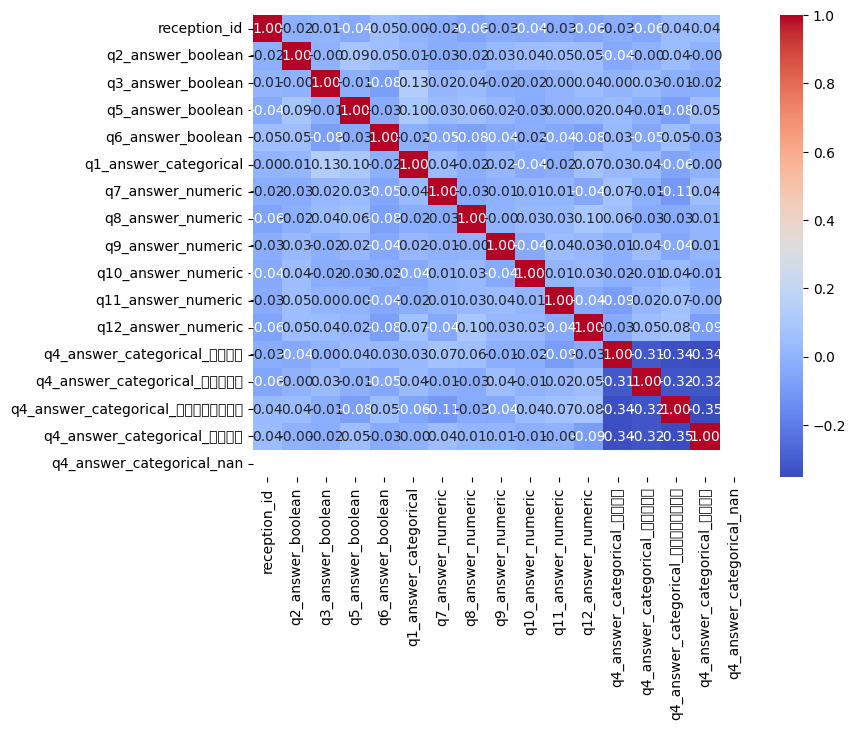

In [28]:
plt.figure(figsize=(8,6))
sns.heatmap(df_encoded.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

多変量可視化（PCA, t-SNE）
ワイドフォーマットのデータ（df_wide_format）から数値データだけを取り出し、欠損値のある行を除外した上で、PCAとt-SNEという次元削減手法を用いてデータを2次元に圧縮し、可視化

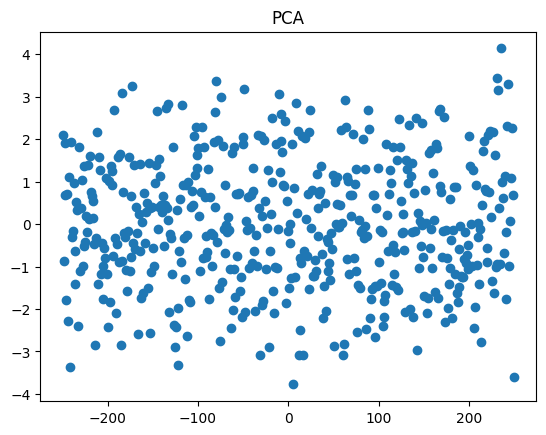

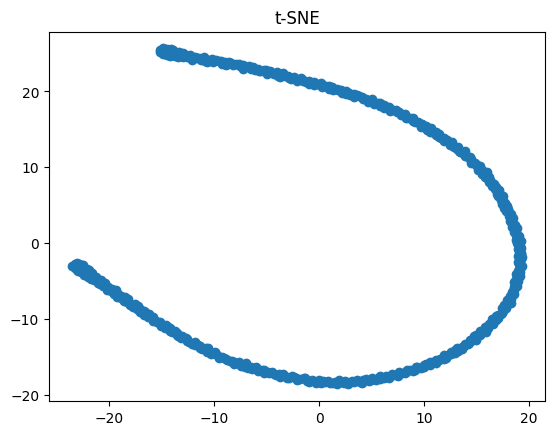

In [29]:
# 数値型のカラムだけを抽出
df_num = df_encoded.select_dtypes(include=['int64','float64']).dropna()

# PCA（主成分分析）を用いて、元の多次元データを2つの主成分に圧縮します。
# 得られた2次元のデータを散布図にプロットすることで、データ全体の大まかな構造や潜在的なクラスタが視覚的に確認できる
pca = PCA(n_components=2).fit_transform(df_num)
plt.scatter(pca[:,0], pca[:,1])
plt.title("PCA")
plt.show()

# t-SNE（t分布型確率的近傍埋め込み）は、局所的な構造をうまく保持する次元削減手法です。
# 同様に2次元に変換したデータを散布図にプロットし、細かなクラスタリングの兆候などを視覚的に把握
tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(df_num)
plt.scatter(tsne[:,0], tsne[:,1])
plt.title("t-SNE")
plt.show()

欠損可視化

c:\Users\堀江雅彦\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12393 (\N{HIRAGANA LETTER DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\堀江雅彦\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12385 (\N{HIRAGANA LETTER TI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\堀江雅彦\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12425 (\N{HIRAGANA LETTER RA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\堀江雅彦\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12418 (\N{HIRAGANA LETTER MO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\堀江雅彦\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\

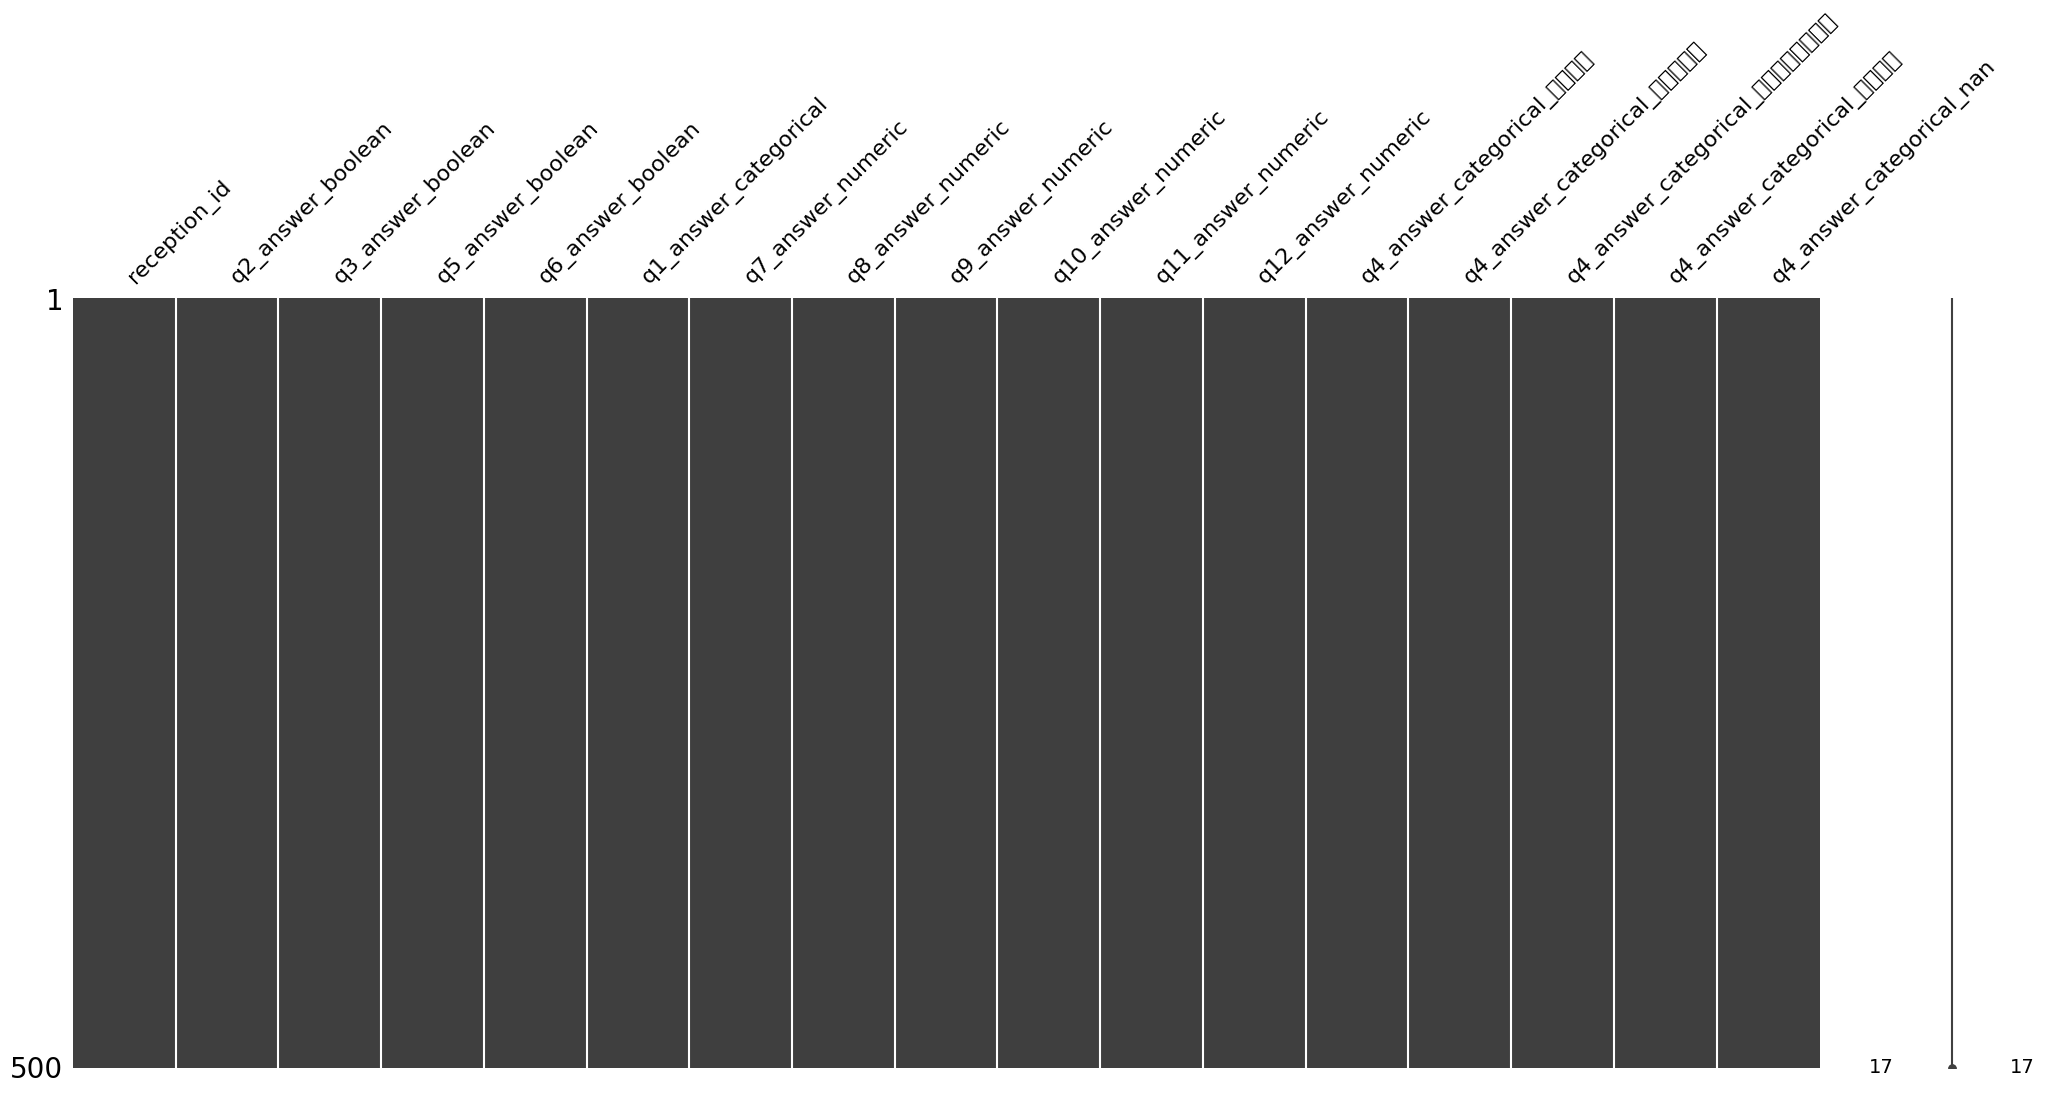

c:\Users\堀江雅彦\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
c:\Users\堀江雅彦\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


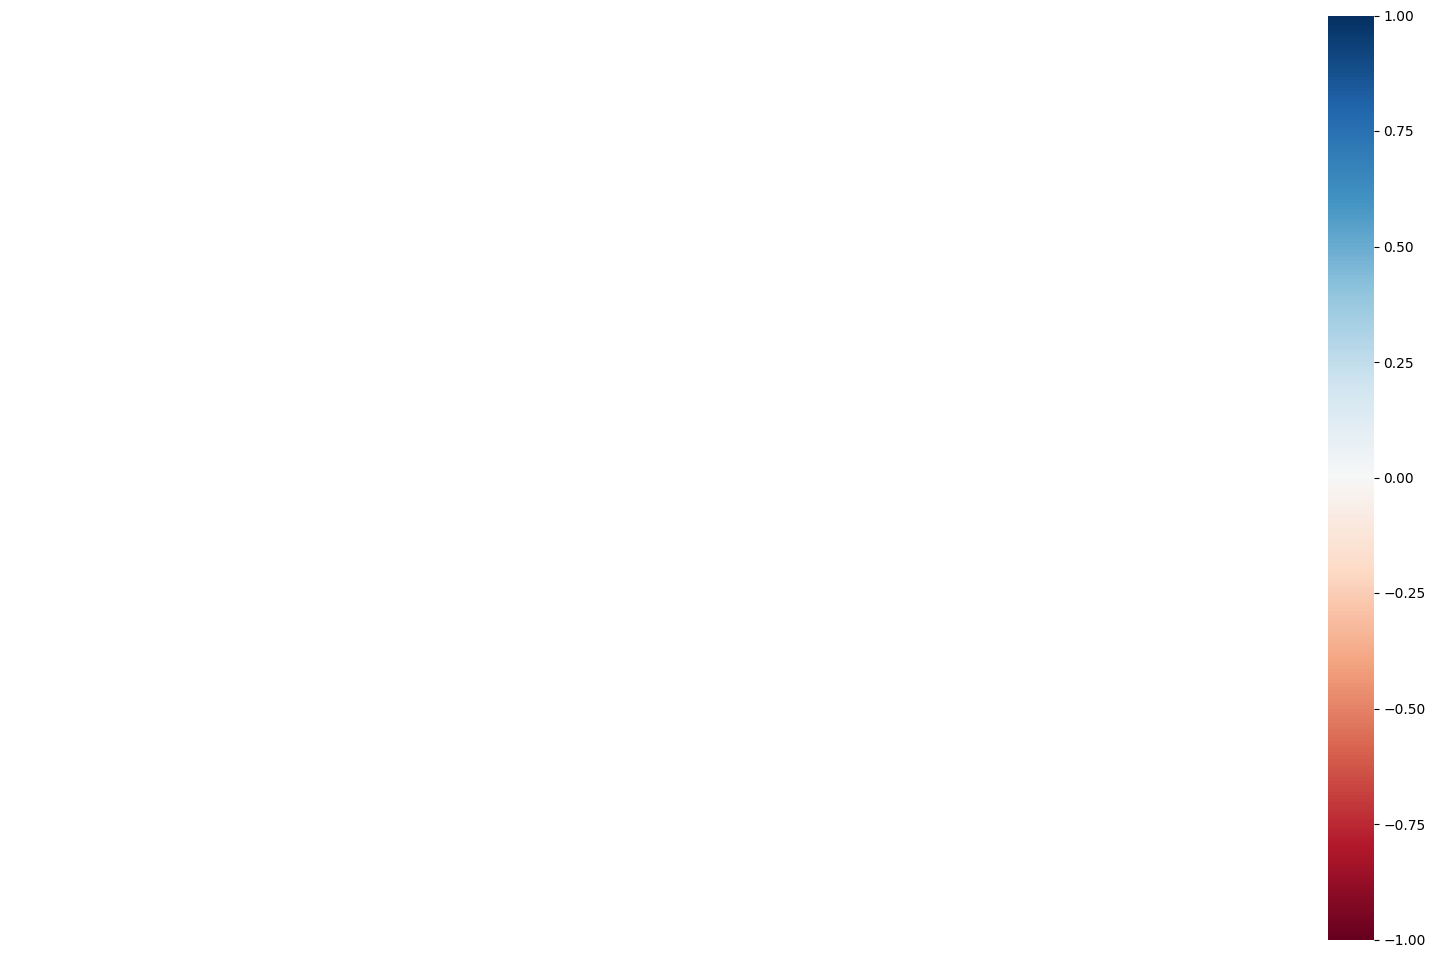

In [30]:
msno.matrix(df_encoded)
plt.show()
msno.heatmap(df_encoded)
plt.show()